# Wedge Coefficients
Nick Zolman

In the following algorithm, we compute a "wedge" version of the clustering coffecient. Where we have a wedge motif (which can be incoming or outgoing, e.g. $a \to c, b \to c$ or $ c \to a, c \to b$). Inspiration come from the intensity of motifs discussed in Onnela et al's paper: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.71.065103

For a given node $a$ with weights $\{a_i\}$ (again, could be incoming or outgoing weights--though not mixed), we calculate the following:

$$ C_{\text{wedge, a}} = \frac{1}{k_a(k_a - 1)}\sum_{i<j} \sqrt{|\hat{a}_i \hat{a}_j|} $$


Where $ \hat{a}_i = \frac{a_i}{ \max_{j} (a_j)}$ is a normalization and $k_a$ is $a$'s incoming or outgoing degree (though not both). 

We calculate this below in the following way:

Let $a$ be an array of weights. $A = a a^T$. Subtract off the diagonal elements of A: $B = A - \text{diag}(A)$. Then we flatten the array, apply the square root to each element, and sum over the elements. We have to divide by 2 to get rid of double counting the elements (we take the sum over all $(i,j)$ and not just when $i < j$. This is purely because I'm lazy, and I'm convinced NumPy is better than "for" loops.




## CODE

In [1]:
import numpy as np

from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/nzolman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# Given an array of weights, calculate the pairwise geometric mean and sum over it
def wedge_cluster(node):
    m = np.max(np.abs(node)) # maxium value
    
    node = node/m  # "normalize" the vector
    
    nodeMat = np.outer(node, node) # Compute the outer product
    
    nodeMat = nodeMat - np.diag(np.diag(nodeMat)) # subtract off the diagonal
    
    sqrtArr = np.sqrt(np.abs(nodeMat.flatten())) # flatten and take the square root
    
    return np.sum(sqrtArr)/(2* node.size * (node.size - 1)) # normalize properly



# Example

In [3]:
# load a test model
model_filename = 'keras_mnist_modelv1.h5'
model = load_model(model_filename)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Incoming Weights
We do this for a dense layer with 128 nodes connected to the flattened result from Max Pooling

In [4]:
# pull in the layer and the incoming weights
dense_layer_in= model.layers[-3]
dense128_incoming = np.array(dense_layer_in.get_weights())[0]

In [5]:
wedge_128_in = np.array([wedge_cluster(node) for node in dense128_incoming.T])

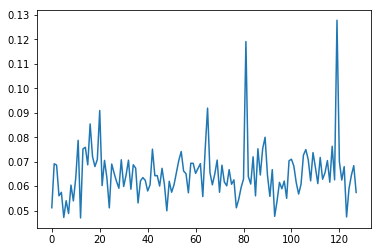

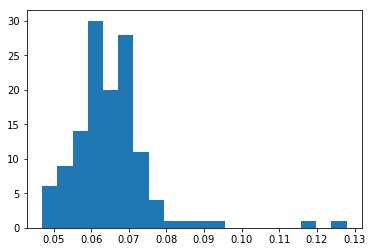

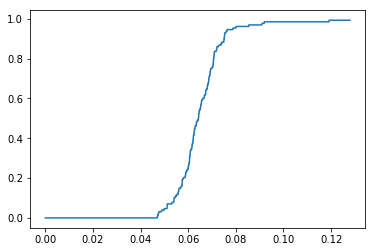

In [6]:
# quick plot to get an idea of relative size
plt.plot(wedge_128_in)
plt.show()

plt.hist(wedge_128_in, 20)
plt.show()

# plot a CDF for the 
thresh_list = np.linspace(0, np.max(wedge_128_in), 6000)

wedge_cumulative = np.array([np.sum(wedge_128_in < thresh) for thresh in thresh_list])
plt.plot(thresh_list, wedge_cumulative/wedge_128_in.size)
plt.show()

## Outgoing Weights
We do this for a dense layer with 128 nodes connected to the flattened result from Max Pooling

In [7]:
dense_layer_out= model.layers[-1]
dense128_outgoing = np.array(dense_layer_out.get_weights())[0]
wedge_128_outgoing = np.array([wedge_cluster(node) for node in dense128_outgoing])

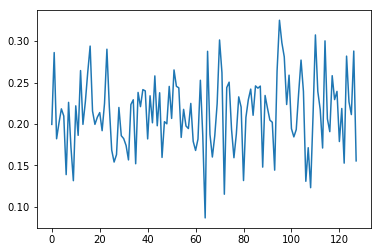

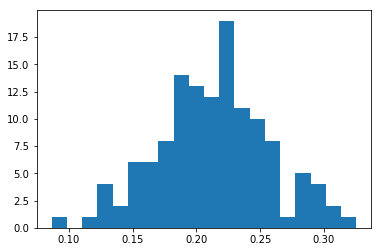

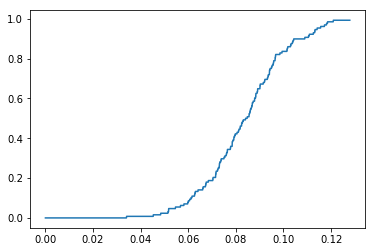

In [8]:
# quick plot to get an idea of relative size
plt.plot(wedge_128_outgoing)
plt.show()

plt.hist(wedge_128_outgoing, 20)
plt.show()

# plot a CDF for the 
thresh_list_out = np.linspace(0, np.max(wedge_128_outgoing), 6000)

wedge_cumulative_out = np.array([np.sum(wedge_128_outgoing < thresh) for thresh in thresh_list_out])
plt.plot(thresh_list, wedge_cumulative_out/wedge_128_outgoing.size)
plt.show()